# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# Load data

In [2]:
# Load feature array
feature = np.load("../Data/X.npy")
print("feature matrix shape: ", feature.shape)

feature matrix shape:  (2062, 64, 64)


In [3]:
# Define a variable to store image size
img_size = feature.shape[1: ]

# Prepare data for analysis

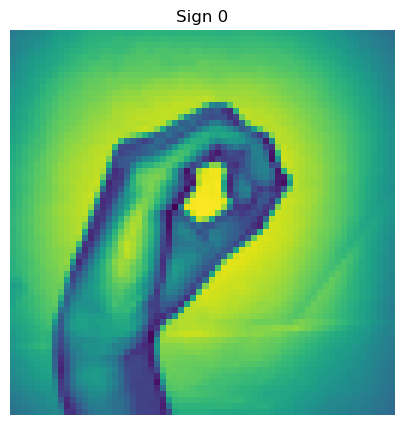

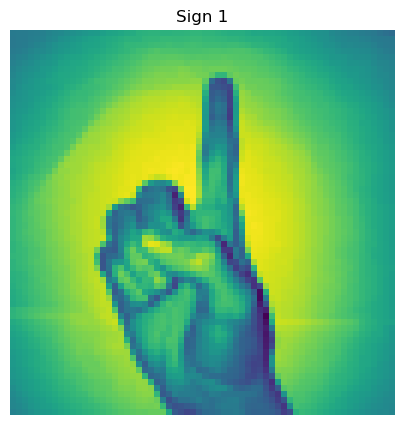

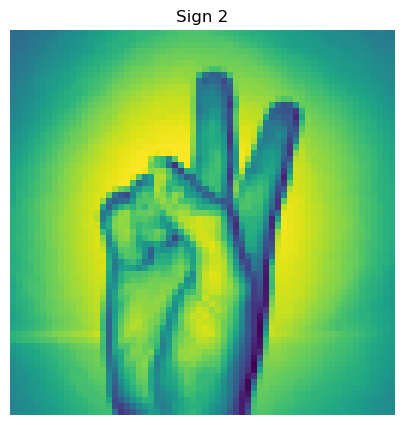

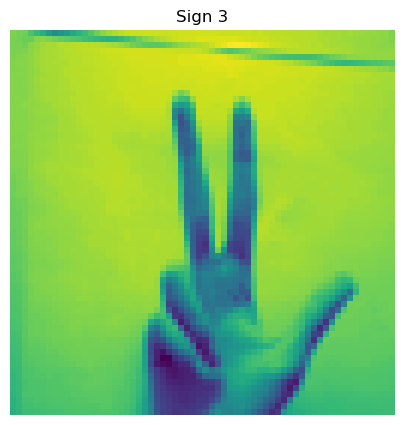

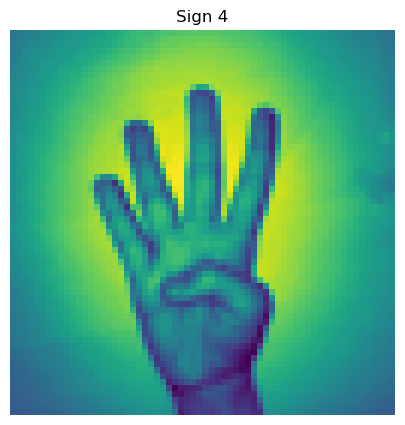

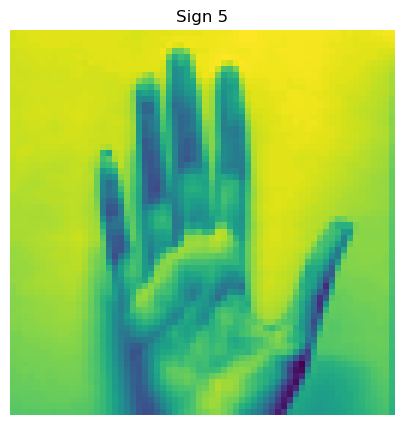

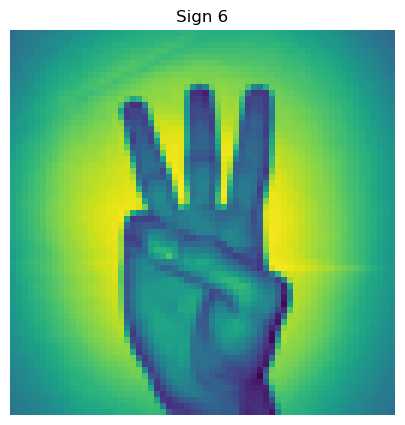

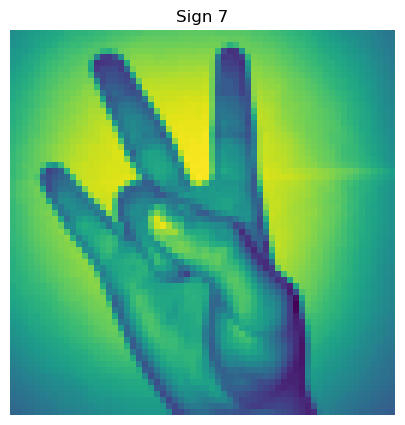

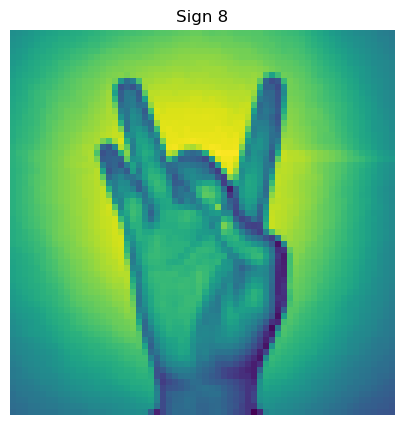

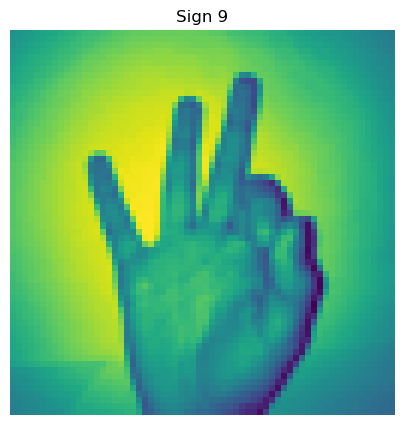

In [4]:
# Select one sample from each digits to visualize sample data
image_index_list = [260, 900, 1800, 1600, 1400, 2061, 700, 500, 1111, 100]

for i, v in enumerate(image_index_list):
    plt.figure(figsize=(8,5))
    plt.imshow(feature[v].reshape(img_size))
    plt.axis('off')
    title = "Sign " + str(i) 
    plt.title(title)

In [5]:
# Split the dataset into training and testing sets
X = feature.reshape((len(feature), -1)) 

# Create train-test split (80-20)
X_full_train, X_full_test = train_test_split(X, test_size=0.2, random_state=42)

# Split into upper and lower halves
n_pixels = X.shape[1]
X_train = X_full_train[:, :(n_pixels + 1) // 2]
X_test = X_full_test[:, :(n_pixels + 1) // 2]
y_train = X_full_train[:, n_pixels // 2:]
y_test = X_full_test[:, n_pixels // 2:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1649, 2048)
(1649, 2048)
(413, 2048)
(413, 2048)


# Ridge Regression

In [6]:
# Scale both upper and lower parts
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Train model
estimator = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
estimator.fit(X_train_scaled, y_train_scaled)

# Predict and inverse transform to get back to original scale
y_test_pred_scaled = estimator.predict(X_test_scaled)
y_test_pred_rr = scaler_y.inverse_transform(y_test_pred_scaled)

# Principal Component Regression (PCR)

## Perform PCA to extract lower-dimension features

In [7]:
# Standardize the Input Features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Dimensionality Reduction with PCA
n_components = 50
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

## Train regression models (on principal components) to complete images

In [8]:
# Principal Component Regression (PCR)
model_pcr = LinearRegression()
model_pcr.fit(X_train_pca, y_train)
y_test_pred_pcr = model_pcr.predict(X_test_pca)

# Kernel Ridge Regression (KRR)

In [9]:
# Scale the data (without PCA)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_std = scaler_X.fit_transform(X_train)
X_test_std = scaler_X.transform(X_test)
y_train_std = scaler_y.fit_transform(y_train)

# Use GridSearchCV to find optimal hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

krr = KernelRidge(kernel='rbf')
grid_search = GridSearchCV(krr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_std, y_train_std)

print(f"Best parameters: {grid_search.best_params_}")

# Use best parameters
model_krr = KernelRidge(kernel='rbf', 
                        alpha=grid_search.best_params_['alpha'],
                        gamma=grid_search.best_params_['gamma'])
model_krr.fit(X_train_std, y_train_std)

# Predict and inverse transform
y_test_pred_krr = scaler_y.inverse_transform(model_krr.predict(X_test_std))

Best parameters: {'alpha': 0.1, 'gamma': 0.0001}


# Evaluate models for image completion

In [10]:
# Defin a function for model evaluation
def model_evalutation(y_test, y_pred, img_size):
    # Compute mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    
    # Compute structural similarity and PSNR
    ssim_list = []
    psnr_list = []
    for i in range(len(y_test)):
        true_lower = y_test[i].reshape(img_size[0] // 2, img_size[1])
        pred_lower = y_pred[i].reshape(img_size[0] // 2, img_size[1])
        
        # Compute SSIM
        ssim_value = ssim(true_lower, pred_lower, data_range=pred_lower.max() - pred_lower.min())
        ssim_list.append(ssim_value)
        
        # Compute PSNR
        mse_i = np.mean((true_lower - pred_lower) ** 2)
        if mse_i == 0:
            psnr = float('inf')
        else:
            psnr = 20 * np.log10(1.0 / np.sqrt(mse_i))
        psnr_list.append(psnr)
    
    average_ssim = np.mean(ssim_list)
    average_psnr = np.mean(psnr_list)

    return {"MSE": mse, "Average SSIM": average_ssim, "Average PSNR": average_psnr}

In [11]:
# Evaluate Ridge Regression
model_eval_rr = model_evalutation(y_test, y_test_pred_rr, img_size)

print(f'Ridge Regression MSE: {model_eval_rr["MSE"]:.4f}') 
print(f'Average SSIM: {model_eval_rr["Average SSIM"]:.4f}')
print(f'Average PSNR: {model_eval_rr["Average PSNR"]:.4f}') 

Ridge Regression MSE: 0.0153
Average SSIM: 0.4045
Average PSNR: 18.5663


In [12]:
# Evaluate PCR
model_eval_PCR = model_evalutation(y_test, y_test_pred_pcr, img_size)

print(f'PCR MSE: {model_eval_PCR["MSE"]:.4f}')
print(f'Average SSIM: {model_eval_PCR["Average SSIM"]:.4f}')
print(f'Average PSNR: {model_eval_PCR["Average PSNR"]:.4f}')

PCR MSE: 0.0131
Average SSIM: 0.4251
Average PSNR: 19.0970


In [13]:
# Evaluate KRR
model_eval_KRR = model_evalutation(y_test, y_test_pred_krr, img_size)

print(f'Kernel Ridge Regression MSE: {model_eval_KRR["MSE"]:.4f}')
print(f'Average SSIM: {model_eval_KRR["Average SSIM"]:.4f}')
print(f'Average PSNR: {model_eval_KRR["Average PSNR"]:.4f}')

Kernel Ridge Regression MSE: 0.0123
Average SSIM: 0.4425
Average PSNR: 19.4289


# Visualize the results

In [16]:
# Randomly choose five images to visualize the image completion results
num_images_to_display = 5

# Create one large figure for all images
fig, axes = plt.subplots(num_images_to_display, 4, figsize=(20, 25))

for i in range(num_images_to_display):
    upper_half = X_test[i].reshape(feature.shape[1] // 2, feature.shape[2])
    true_lower_half = y_test[i].reshape(feature.shape[1] // 2, feature.shape[2])
    pred_lower_half_pcr = y_test_pred_pcr[i].reshape(feature.shape[1] // 2, feature.shape[2])
    pred_lower_half_krr = y_test_pred_krr[i].reshape(feature.shape[1] // 2, feature.shape[2])
    pred_lower_half_ridge = y_test_pred_rr[i].reshape(feature.shape[1] // 2, feature.shape[2])

    # Combine upper and lower halves
    original_image = np.vstack([upper_half, true_lower_half])
    reconstructed_pcr = np.vstack([upper_half, pred_lower_half_pcr])
    reconstructed_krr = np.vstack([upper_half, pred_lower_half_krr])
    reconstructed_ridge = np.vstack([upper_half, pred_lower_half_ridge])
    
    # Plotting in the corresponding row
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_pcr)
    axes[i, 1].set_title('PCR Reconstruction')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(reconstructed_krr)
    axes[i, 2].set_title('KRR Reconstruction')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(reconstructed_ridge)
    axes[i, 3].set_title('Ridge Reconstruction')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig("image_completion_comparison.png", bbox_inches='tight', dpi=300)
plt.close()